In [1]:
import numpy as np
import pandas as pd
from random import shuffle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets, models
from train import train_model, train_loss, train_accuracy, val_loss, val_accuracy
from torchsummary import summary
import time
import copy
import seaborn as sns
sns.set(font_scale=1.4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 16


dataset = torch.load('../datasets/dataset.pt')
lengths = [

    int(len(dataset) * 0.8),
    int(len(dataset) * 0.1),
    int(len(dataset) * 0.1) + 1
]

trainset, valset, testset = random_split(dataset, lengths)
image_datasets = {'train': trainset, 'val': valset, 'test': testset}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}  

In [2]:
class MultiCNN(nn.Module):
    def __init__(self):
        super(MultiCNN, self).__init__()
        self.fc1 = nn.Linear(6144, 256)
        self.fc2 = nn.Linear(256, 2)
        self.fc3 = nn.Linear(10, 2)
        resnet = models.resnet50(pretrained=True).to(device) 
        self.new_resnet1 = nn.Sequential(*list(resnet.children())[:-1])
        self.new_resnet2 = nn.Sequential(*list(resnet.children())[:-1])
        self.new_resnet3 = nn.Sequential(*list(resnet.children())[:-1])
        self.drop = nn.Dropout(p=0.5)
        
    def forward(self, x_slices):

        x1 = x_slices[0]
        x1 = self.new_resnet1(x1)
        x1 = x1.view(-1, 2048)

        x2 = x_slices[1]
        x2 = self.new_resnet2(x2)
        x2 = x2.view(-1, 2048)

        x3 = x_slices[2]
        x3 = self.new_resnet3(x3)
        x3 = x3.view(-1, 2048)

        out = torch.cat((x1, x2, x3), dim=-1)
        out = F.relu(self.drop(self.fc1(out)))
        out = F.relu(self.fc2(out))

        return out

Epoch 0/24
----------------------------------------------------------------------------------------------------



train Loss: 0.6391 Acc: 0.5900



val Loss: 0.5227 Acc: 0.6017
Epoch 1/24
----------------------------------------------------------------------------------------------------



train Loss: 0.4830 Acc: 0.6049



val Loss: 0.6105 Acc: 0.6186
Epoch 2/24
----------------------------------------------------------------------------------------------------



train Loss: 0.2867 Acc: 0.8867



val Loss: 0.4997 Acc: 0.7966
Epoch 3/24
----------------------------------------------------------------------------------------------------



train Loss: 0.1819 Acc: 0.9258



val Loss: 0.2960 Acc: 0.9068
Epoch 4/24
----------------------------------------------------------------------------------------------------



train Loss: 0.1108 Acc: 0.9629



val Loss: 0.3104 Acc: 0.8644
Epoch 5/24
----------------------------------------------------------------------------------------------------



train Loss: 0.1240 Acc: 0.9566



val Loss: 0.5839 Acc: 0.8644
Epoch 6/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0855 Acc: 0.9650



val Loss: 0.4512 Acc: 0.8390
Epoch 7/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0424 Acc: 0.9894



val Loss: 0.3551 Acc: 0.8729
Epoch 8/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0157 Acc: 0.9989



val Loss: 0.4279 Acc: 0.8729
Epoch 9/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0228 Acc: 0.9958



val Loss: 0.3672 Acc: 0.8814
Epoch 10/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0185 Acc: 0.9958



val Loss: 0.4637 Acc: 0.8729
Epoch 11/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0126 Acc: 0.9979



val Loss: 0.4468 Acc: 0.8814
Epoch 12/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0117 Acc: 0.9989



val Loss: 0.4117 Acc: 0.8814
Epoch 13/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0119 Acc: 1.0000



val Loss: 0.3600 Acc: 0.8898
Epoch 14/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0085 Acc: 0.9989



val Loss: 0.4122 Acc: 0.8898
Epoch 15/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0107 Acc: 0.9989



val Loss: 0.5184 Acc: 0.8729
Epoch 16/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0091 Acc: 0.9989



val Loss: 0.3831 Acc: 0.8898
Epoch 17/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0068 Acc: 1.0000



val Loss: 0.3633 Acc: 0.8898
Epoch 18/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0112 Acc: 0.9989



val Loss: 0.3599 Acc: 0.8983
Epoch 19/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0063 Acc: 1.0000



val Loss: 0.3808 Acc: 0.8983
Epoch 20/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0138 Acc: 0.9968



val Loss: 0.3943 Acc: 0.8898
Epoch 21/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0106 Acc: 0.9979



val Loss: 0.5693 Acc: 0.8898
Epoch 22/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0079 Acc: 0.9989



val Loss: 0.4254 Acc: 0.8814
Epoch 23/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0058 Acc: 1.0000



val Loss: 0.4072 Acc: 0.8814
Epoch 24/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0096 Acc: 0.9989



val Loss: 0.3723 Acc: 0.8898
Training complete in 7m 58s
Best val Acc: 0.906780


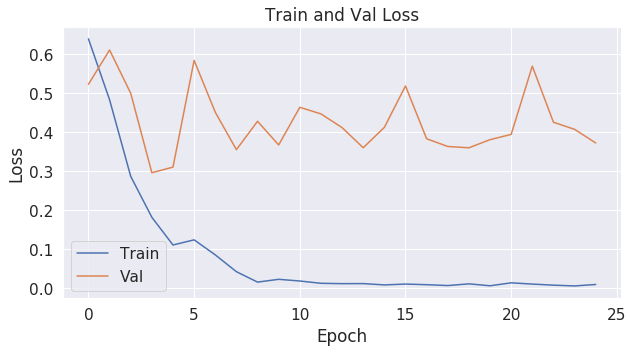

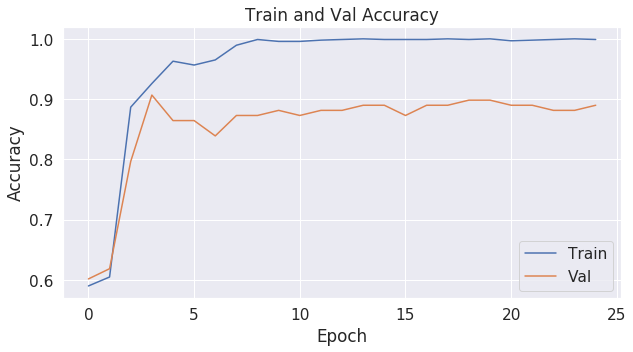

In [3]:
model = MultiCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders, dataset_sizes,
                       num_epochs=25, batch_size = batch_size)

In [4]:
running_loss = 0.0
running_corrects = 0
for inputs, labels in tqdm(dataloaders['test'], total = dataset_sizes['test']//16+1):
    labels = labels.to(device)
    inputs = [i.to(device, dtype = torch.float) for i in inputs]

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)


    running_loss += loss.item() * 16
    running_corrects += torch.sum(preds == labels.data)
    
print(f"Test Loss: {running_loss / dataset_sizes['test']}\nTest Accuracy: {running_corrects.double() / dataset_sizes['test']}")



Test Loss: 0.45582570198203337
Test Accuracy: 0.8403361344537815


In [ ]:
from confusionmatrix import make_confusion_matrix

nb_classes = 2
sns.set(font_scale=2)
cf = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        classes = classes.to(device)
        inputs = [i.to(device, dtype=torch.float) for i in inputs]
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for t, p in zip(classes.view(-1), preds.view(-1)):
            cf[t.long(), p.long()] += 1

cf = np.array(cf)

group_names = ['bruh','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf.reshape(-1)/cf.sum()]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

make_confusion_matrix(cf, group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize= (10,7),
                          cmap='Blues',
                          title='Resnet 50 \n')